### Analysis of infection based on SEIR model  
- Data from JHU CSSE COVID-19 Dataset
 - https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series  

#### Import libraries  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import minimize

#### Parameters  

In [2]:
csv_in = 'time_series_covid19-japan.20200301-20200419.csv'

dt = 0.01  # for odeint

#### Definition of differencial equations of SEIR model  
- S: #Susceptible = the number of people who are not immune
 - 影響を受けやすい = 免疫を持たない人数  
- E: #Exposed = the number of people who are infected and during the incubation period
 - 曝露されている = 感染し、かつ潜伏期間中の人数
- I: #Infectious = the number of people who are onset
 - 伝染性のある = すでに発症している人数
- R: #Removed = the number of people who have been infected and are recovered (have immunity) or dead
 - この系から取り除かれた = 免疫を獲得した or 死亡した人数
- beta: infectious rate (S -> E, 感染率)
- lp: length of latent period (incubation period, E -> I, 潜伏期間)
- ip: length of infectious period (I -> R, 感染期間)

In [3]:
def seir_eq(v, t, beta, lp, ip):
    S, E, I, R = v
    dSdt = -beta * S * I
    dEdt = beta * S * I - E / lp
    dIdt = E / lp - I / ip
    dRdt = I / ip
    return dSdt, dEdt, dIdt, dRdt

#### Function to estimate S,E,I,R from SEIR model with given parameters   

In [4]:
def estimate_seir(seir_eq, init_state, t, beta, lp, ip, num_t, step_t):
    sol = odeint(seir_eq, init_state, t, args=(beta, lp, ip))
    est = sol[0:num_t:step_t]
    return est

#### Read CSV file  

In [5]:
df = pd.read_csv(csv_in, sep=',', skiprows=0, header=0)
print(df.shape)
print(df.info())
display(df.head())
display(df.tail())

(50, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          50 non-null     object
 1   Confirmed     50 non-null     int64 
 2   Recovered     50 non-null     int64 
 3   Deaths        50 non-null     int64 
 4   Removed_tot   50 non-null     int64 
 5   Infected_tot  50 non-null     int64 
dtypes: int64(5), object(1)
memory usage: 2.5+ KB
None


,Date,Confirmed,Recovered,Deaths,Removed_tot,Infected_tot
0,2020-03-01,15,1,0,16,175
1,2020-03-02,16,1,0,17,190
2,2020-03-03,17,3,0,20,204
3,2020-03-04,20,3,0,23,221
4,2020-03-05,21,3,0,26,239


,Date,Confirmed,Recovered,Deaths,Removed_tot,Infected_tot
45,2020-04-15,545,33,11,852,6420
46,2020-04-16,540,38,13,903,6909
47,2020-04-17,529,35,13,951,7390
48,2020-04-18,513,43,14,1008,7846
49,2020-04-19,491,56,15,1079,8266


In [6]:
df['Date'] = pd.to_datetime(df['Date'])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          50 non-null     datetime64[ns]
 1   Confirmed     50 non-null     int64         
 2   Recovered     50 non-null     int64         
 3   Deaths        50 non-null     int64         
 4   Removed_tot   50 non-null     int64         
 5   Infected_tot  50 non-null     int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 2.5 KB
None


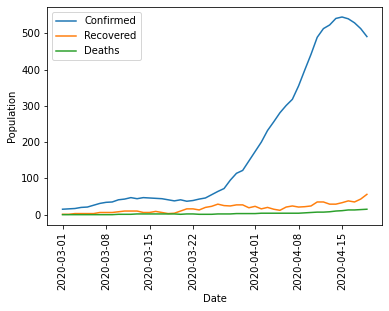

In [7]:
plt.plot(df['Date'], df['Confirmed'], label='Confirmed')
plt.plot(df['Date'], df['Recovered'], label='Recovered')
plt.plot(df['Date'], df['Deaths'], label='Deaths')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Population')
plt.legend()
plt.show()

In [8]:
obs_i = df['Infected_tot']
obs_r = df['Removed_tot']
print((obs_i+obs_r).max())

9345


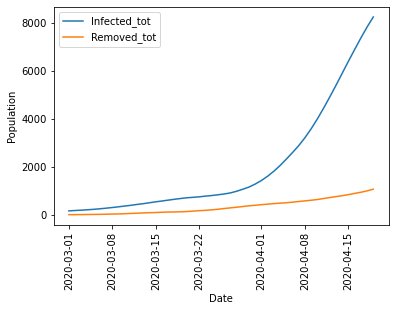

In [9]:
plt.plot(df['Date'], obs_i, label='Infected_tot')
plt.plot(df['Date'], obs_r, label='Removed_tot')
plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Population')
plt.legend()
plt.show()

#### Define t  

In [10]:
t_max = len(obs_i)
t = np.arange(0, t_max, dt)
num_t = int(t_max/dt)
step_t = int(1/dt)

#### Objective function: mean square deviation of I and R    

In [11]:
def y(params, seir_eq, init_state, t, num_t, step_t):
    beta, lp, ip = params
    est = estimate_seir(seir_eq, init_state, t, beta, lp, ip, num_t, step_t)
    est_i = est[:, 2]
    est_r = est[:, 3]
    diff_i = est_i - obs_i
    diff_r = est_r - obs_r
    return np.sum(diff_i*diff_i + diff_r*diff_r)

#### Optimize the objective function  

In [12]:
init_S = 20000
init_E = 100
init_I = 15
init_R = 1
init_state = [init_S, init_E, init_I, init_R]
n_population = np.sum(init_state)

init_beta = 0.3 / n_population
init_lp = 2.0
init_ip = 7.0

init_params = [init_beta, init_lp, init_ip]
results = minimize(y, init_params, args=(seir_eq, init_state, t, num_t, step_t),
                   method='nelder-mead')

print(results)

 final_simplex: (array([[1.14730727e-05, 6.42667617e+00, 7.37262915e+01],
       [1.14730727e-05, 6.42667617e+00, 7.37262915e+01],
       [1.14730727e-05, 6.42667617e+00, 7.37262915e+01],
       [1.14730727e-05, 6.42667617e+00, 7.37262915e+01]]), array([3046514.48568956, 3046514.4856898 , 3046514.48569068,
       3046514.4856908 ]))
           fun: 3046514.485689559
       message: 'Optimization terminated successfully.'
          nfev: 436
           nit: 226
        status: 0
       success: True
             x: array([1.14730727e-05, 6.42667617e+00, 7.37262915e+01])


In [13]:
init_beta

1.4913501690196859e-05

#### Analysis of the results of the optimization  
- R0: basic reproduction number (基本再生産数)
 - the number of secondary infections generated by the first infectious individual in a fully susceptible population over the course of the infectious period (周りが全員Sのとき、1人のIが何人に感染させるか)

In [14]:
beta_opt = results.x[0]
lp_opt = results.x[1]
ip_opt = results.x[2]

print('Optimized parameters:')
print('  beta:', beta_opt)
print('  lp:', lp_opt)
print('  ip:', ip_opt)
R0 = beta_opt * n_population * ip_opt
print('R0:', R0)

Optimized parameters:
  beta: 1.147307273337159e-05
  lp: 6.426676172201214
  ip: 73.72629154293804
R0: 17.01546268888487


#### Result of the fitting to #Infected    

In [15]:
t_max = len(obs_i)
t = np.arange(0, t_max, dt)
num_t = int(t_max/dt)
step_t = int(1/dt)
print('t_max:', t_max)
est = estimate_seir(seir_eq, init_state, t, beta_opt, lp_opt, ip_opt, num_t, step_t)

t_max: 50


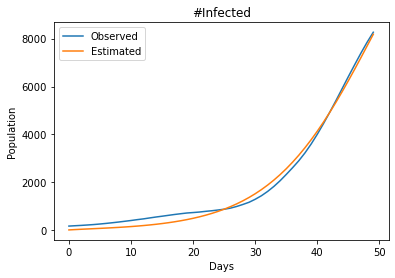

In [16]:
est_i = est[:, 2]
plt.plot(obs_i, label='Observed')
plt.plot(est_i, label='Estimated')
plt.title('#Infected')
plt.xlabel('Days')
plt.ylabel('Population')
plt.legend()
plt.show()

#### Result of the fitting to #Removed    

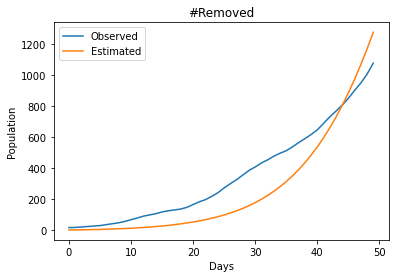

In [17]:
est_r = est[:, 3]
plt.plot(obs_r, label='Observed')
plt.plot(est_r, label='Estimated')
plt.title('#Removed')
plt.xlabel('Days')
plt.ylabel('Population')
plt.legend()
plt.show()

#### Solve SEIR model  

In [23]:
init_state

[20000, 100, 15, 1]

t_max: 300


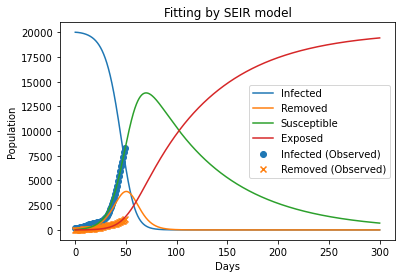

In [22]:
t_max = 300
t = np.arange(0, t_max, dt)
num_t = int(t_max/dt)
step_t = int(1/dt)
print('t_max:', t_max)

sol = odeint(seir_eq, init_state, t, args=(beta_opt, lp_opt, ip_opt))
t_obs_i = range(len(obs_i))
plt.scatter(t_obs_i, obs_i, marker='o')
t_obs_r = range(len(obs_r))
plt.scatter(t_obs_r, obs_r, marker='x')
plt.plot(t, sol)
plt.title('Fitting by SEIR model')
plt.xlabel('Days')
plt.ylabel('Population')
labels = ['Infected', 'Removed', 'Susceptible', 'Exposed',
          'Infected (Observed)', 'Removed (Observed)']
plt.legend(labels)
plt.show()

In [19]:
csv_in2 = 'time_series_covid19-japan.20200301-20200624.csv'
df2 = pd.read_csv(csv_in2, sep=',', skiprows=0, header=0)
print(df2.shape)
print(df2.info())
display(df2.head())
display(df2.tail())

(116, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          116 non-null    object
 1   Confirmed     116 non-null    int64 
 2   Recovered     116 non-null    int64 
 3   Deaths        116 non-null    int64 
 4   Removed_tot   116 non-null    int64 
 5   Infected_tot  116 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 5.6+ KB
None


,Date,Confirmed,Recovered,Deaths,Removed_tot,Infected_tot
0,2020-03-01,15,1,0,16,175
1,2020-03-02,16,1,0,17,190
2,2020-03-03,17,3,0,20,204
3,2020-03-04,20,3,0,23,221
4,2020-03-05,21,3,0,26,239


,Date,Confirmed,Recovered,Deaths,Removed_tot,Infected_tot
111,2020-06-20,61,70,4,16552,919
112,2020-06-21,58,62,4,16618,911
113,2020-06-22,54,55,3,16676,907
114,2020-06-23,56,63,4,16743,896
115,2020-06-24,61,49,4,16796,904


In [20]:
df2['Date'] = pd.to_datetime(df2['Date'])
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          116 non-null    datetime64[ns]
 1   Confirmed     116 non-null    int64         
 2   Recovered     116 non-null    int64         
 3   Deaths        116 non-null    int64         
 4   Removed_tot   116 non-null    int64         
 5   Infected_tot  116 non-null    int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 5.6 KB
None


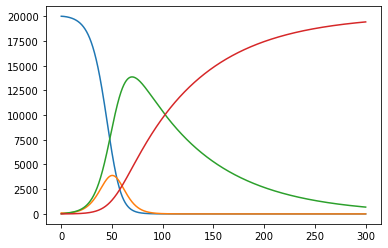

In [24]:
#plt.plot(t, sol)

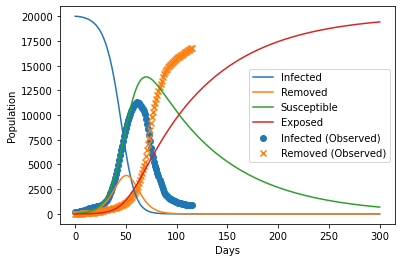

In [21]:
obs_i2 = df2['Infected_tot']
obs_r2 = df2['Removed_tot']
t_obs_i2 = range(len(obs_i2))
plt.scatter(t_obs_i2, obs_i2, marker='o')
t_obs_r2 = range(len(obs_r2))
plt.scatter(t_obs_r2, obs_r2, marker='x')
plt.plot(t, sol)
plt.xlabel('Days')
plt.ylabel('Population')
labels = ['Infected', 'Removed', 'Susceptible', 'Exposed',
          'Infected (Observed)', 'Removed (Observed)']
plt.legend(labels)
plt.show()

**The difference of the predicted and observed values may caused by our social isolation activities...**  
**見積もりと実際の数値のずれは、社会的隔離の取り組みの成果かもしれない...**